In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

## authorship information
__author__ = "Alex Tavkhelidze"<br>
__credits__ = ["Bernd Brinkmann", "Luigi Menale", "Arif Haidari", "Romain Lesieur"]<br>
__email__ = <a href="mailto:&#106;&#101;&#111;&#115;&#064;&#109;&#097;&#105;&#108;&#046;&#099;&#111;&#109;">jeos [at] mail [dot] com</a><br>
__status__ = "Development"<br>
__project__ = "Plant Recognition"<br>
__scope__ = "DataScientest's Bootcamp in Data Science"

#### materials used besides own contribution:
code file '3_Gender_detection_corrigé.ipynb', provided in the DataScientest's training module 'Convolutional Neural Networks with Keras'<br>
code file '151.2_1_CNN_en.ipynb', provided in the DataScientest's training module 'Convolutional Neural Networks with Keras'<br>
https://www.datacamp.com/tutorial/complete-guide-data-augmentation<br>
https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker<br>
https://stackoverflow.com/questions/71129505/is-it-possible-to-split-a-tensorflow-dataset-into-train-validation-and-test-dat<br>
https://stackoverflow.com/questions/74156503/how-to-get-labels-for-confusion-matrix-from-image-dataset-from-directory-in-kera<br>
https://stackoverflow.com/questions/45662253/can-i-run-keras-model-on-gpu<br>
https://stackoverflow.com/questions/41402409/tensorflow-doesnt-seem-to-see-my-gpu<br>
https://medium.com/@siddheshb008/lenet-5-architecture-explained-3b559cb2d52b<br>
https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7<br>
https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
"""Builds the following 3 steps of the Deep Learning Pipeline:
   preprocesses & splits the data into training and validation subsets, the latter being further divided in testing and validation parts
   composes & compiles & fits/trains the custom-built augmentation-aided CNN on the basis of LeNet-5 architecture
   analyzes the performance via classification report (derivatives), confusion matrices and accuracy/loss evolution plots
"""

In [12]:
import os
import multiprocessing

import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from scipy.stats import linregress
from scipy.stats import skewnorm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# checks whether GPU(s) is(are) supported: if supported, the output will contain entries with "GPU"
# TODO: in case GPU is not supported, make sure GPU usage is activated
# [e.g. for Google Colab: Menu->Laufzeit->Laufzeittyp ändern-> Hardwarebeschleuniger -> (T4) GPU]
print("GPU not available/supported" if "GPU" not in device_lib.list_local_devices() else device_lib.list_local_devices())

# displays the number of online CPUs
num_of_cpu_cores = multiprocessing.cpu_count()
print("# of CPU cores:",num_of_cpu_cores)

In [3]:
# mounts the Google Drive to the Google Colab server (i.e. to the remote machine with Linux OS):
# ACHTUNG: run this only once per Google Colab session
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
# upzipping the zip-archive of the entire raw dataset stored on the mounted Google Drive to the Google Colab's local directory

# TODO: replace the path with your full path to the .zip file
# ACHTUNG: run this only once per Google Colab session
!unzip -qq "/content/drive/My Drive/raw.zip" 

In [14]:
# TODO: replace the arguments with your full path directory names

# assuming 'raw' is the main directory containing all the class-representing folders with respective image files
dataset_dir = os.path.join(os.sep, "content", "raw")

# defining the path for saving the (Keras) model:
model_save_path_to_file = os.path.join(os.sep,"content","drive","My Drive","model.keras")

In [16]:
# preprocesses and splits the dataset in training and (testing and)validation subsets

px_rescale = 1./255
seed_train_validation = 123321 # Must be same for train_ds and val_ds
labels = "inferred" # default value: takes respective image-containing folder names as (class) labels
label_mode = "int" # default value: encodes fetched (class) labels numerically -> used for 'sparse_categorical_crossentropy' loss
shuffle_value = True
validation_split = 0.3 # widely-used {validation,test}/{train,validation,test} ratio
batch_size = 32
AUTOTUNE = batch_size # TODO: another universal option would be the constant 'tf.data.AUTOTUNE'
color_mode = 'grayscale'
image_size = (128, 128) 
interpolation = 'bilinear' 

train_ds = tf.keras.utils.image_dataset_from_directory(
directory = dataset_dir,
labels = labels,
label_mode = label_mode,
image_size = image_size,
interpolation = interpolation,
validation_split = validation_split,
subset = "training",
seed = seed_train_validation,
color_mode = color_mode,
shuffle = shuffle_value,
batch_size = batch_size)
class_names = train_ds.class_names
n_img_labels = len(train_ds.class_names)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
directory = dataset_dir,
labels = labels,
label_mode = label_mode,
image_size = image_size,
interpolation = interpolation,
validation_split = validation_split,
subset = "validation",
seed = seed_train_validation,
color_mode = color_mode,
shuffle = shuffle_value,
batch_size = batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3) # takes (2/3 of 30% = 20% of dataset) elements up to a specified position starting from the first element
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.skip((2*val_batches) // 3) # skips (i.e. retains the rest 10%) elements up to a specified position starting from the first element
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())

Found 60987 files belonging to 51 classes.
Using 42691 files for training.
Found 60987 files belonging to 51 classes.
Using 18296 files for validation.
Batches for testing --> tf.Tensor(381, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(191, shape=(), dtype=int64)


In [17]:
# helper function
def right_skewed_distr(magnitude, pool_size, min_n, max_n):
  """Picks a random number from the tuned right-skewed distribution.

  Args:
      magnitude: skewness parameter (magnitude = 0 is identical to a normal distribution)
      pool_size: sample size drawn from the distribution
      min_n: left margin of the sample
      max_n: right margin of the sample

  Returns:
      a number, randomly chosen from the selectively margined sample of preset size drawn from the right-skewed distribution
  """
  r = skewnorm.rvs(magnitude, size=pool_size)
  r_min = min(r)
  r_max = max(r)
  r_rng = max(r) - min(r)
  r_minmax = (r - r_min)/r_rng
  r_scaled = r_minmax *(max_n - min_n) + min_n
  return np.random.choice(r_scaled)

In [18]:
# building & compiling & [callback-supported and augmentation-aided] learning of the sequential CNN (essentially based on LeNet-5 architecture)

n_chn = dict(rgb = 3, grayscale = 1)
input_shape = image_size + (n_chn[color_mode],)
flip_ax = "horizontal_and_vertical"
zoom_in_rng = (-0.2, 0)
contr_1plumin_rng = (0, 1)
brig_rng = (-0.2, 0.2)
skew_mgn = 100
skew_dist_size = 1000
gaus_noise_std = right_skewed_distr(skew_mgn, skew_dist_size, 0, 0.1)
lambda_L2 = 0.0001
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
epochs = 100

model = tf.keras.Sequential()
#<preprocessing layers>
#<augmentation layers>
model.add(tf.keras.layers.RandomFlip(flip_ax))
model.add(tf.keras.layers.RandomZoom(zoom_in_rng))
model.add(tf.keras.layers.RandomContrast(contr_1plumin_rng))
model.add(tf.keras.layers.RandomBrightness(brig_rng))
#<preprocessing layer>
model.add(tf.keras.layers.Rescaling(px_rescale))
#</preprocessing layer>
model.add(tf.keras.layers.GaussianNoise(gaus_noise_std))
#</augmentation layers>
#</preprocessing layers>
model.add(tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, padding='valid', strides = 1, activation='relu', use_bias=True))
model.add(tf.keras.layers.AveragePooling2D(pool_size = 2, strides = 2, padding='valid'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 5, padding='valid', strides = 1, activation='relu', use_bias=True,))
model.add(tf.keras.layers.AveragePooling2D(pool_size = 2, strides = 2, padding='valid'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate = 0.2))
model.add(tf.keras.layers.Conv2D(filters = 120, kernel_size = 5, padding='valid', strides = 1, activation='relu', use_bias=True, kernel_regularizer = tf.keras.regularizers.l2(l2=lambda_L2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate = 0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 84, activation='relu', use_bias=True, kernel_regularizer = tf.keras.regularizers.l2(l2=lambda_L2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate = 0.2))
model.add(tf.keras.layers.Dense(units = n_img_labels, activation='softmax'))

model.compile(optimizer = optimizer,
              loss = loss,
              metrics=['accuracy'])

# loading the existing/saved model
# model (e.g. the best performing one from previous training(s)) can be loaded as:
# TODO: if the saved model is loaded, the upper lines of building and compiling the model should be commented out
# model = tf.keras.models.load_model(model_save_path_to_file)

early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 15,
                        verbose=2,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=5,
                            factor=0.75,
                            verbose=2,
                            mode='min')

model_checkpoint = callbacks.ModelCheckpoint( # creates a file 'model.keras' - slows down only once during the first save
    filepath=model_save_path_to_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq = "epoch")

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs,
  callbacks = [early_stopping,lr_plateau,model_checkpoint]
)

Epoch 1/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.3744 - loss: 2.5499 - val_accuracy: 0.6073 - val_loss: 1.6229 - learning_rate: 0.0010
Epoch 2/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 126s 94ms/step - accuracy: 0.6197 - loss: 1.5554 - val_accuracy: 0.5719 - val_loss: 1.9416 - learning_rate: 0.0010
Epoch 3/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 95s 71ms/step - accuracy: 0.6734 - loss: 1.5242 - val_accuracy: 0.6053 - val_loss: 1.8451 - learning_rate: 0.0010
Epoch 4/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 95s 71ms/step - accuracy: 0.7046 - loss: 1.5523 - val_accuracy: 0.3612 - val_loss: 3.4732 - learning_rate: 0.0010
Epoch 5/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 95s 71ms/step - accuracy: 0.6608 - loss: 1.8396 - val_accuracy: 0.6722 - val_loss: 1.7053 - learning_rate: 0.0010
Epoch 6/100
1334/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7253 - loss: 1.5904
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step -

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_2             │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 128, 128, 1)    │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 62, 62, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 62, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 29, 29, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 29, 29, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 120)    │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25, 25, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 25, 25, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 75000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │     6,300,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 84)             │           336 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,067,143 (72.74 MB)

 Trainable params: 6,355,563 (24.24 MB)

 Non-trainable params: 452 (1.77 KB)

 Optimizer params: 12,711,128 (48.49 MB)

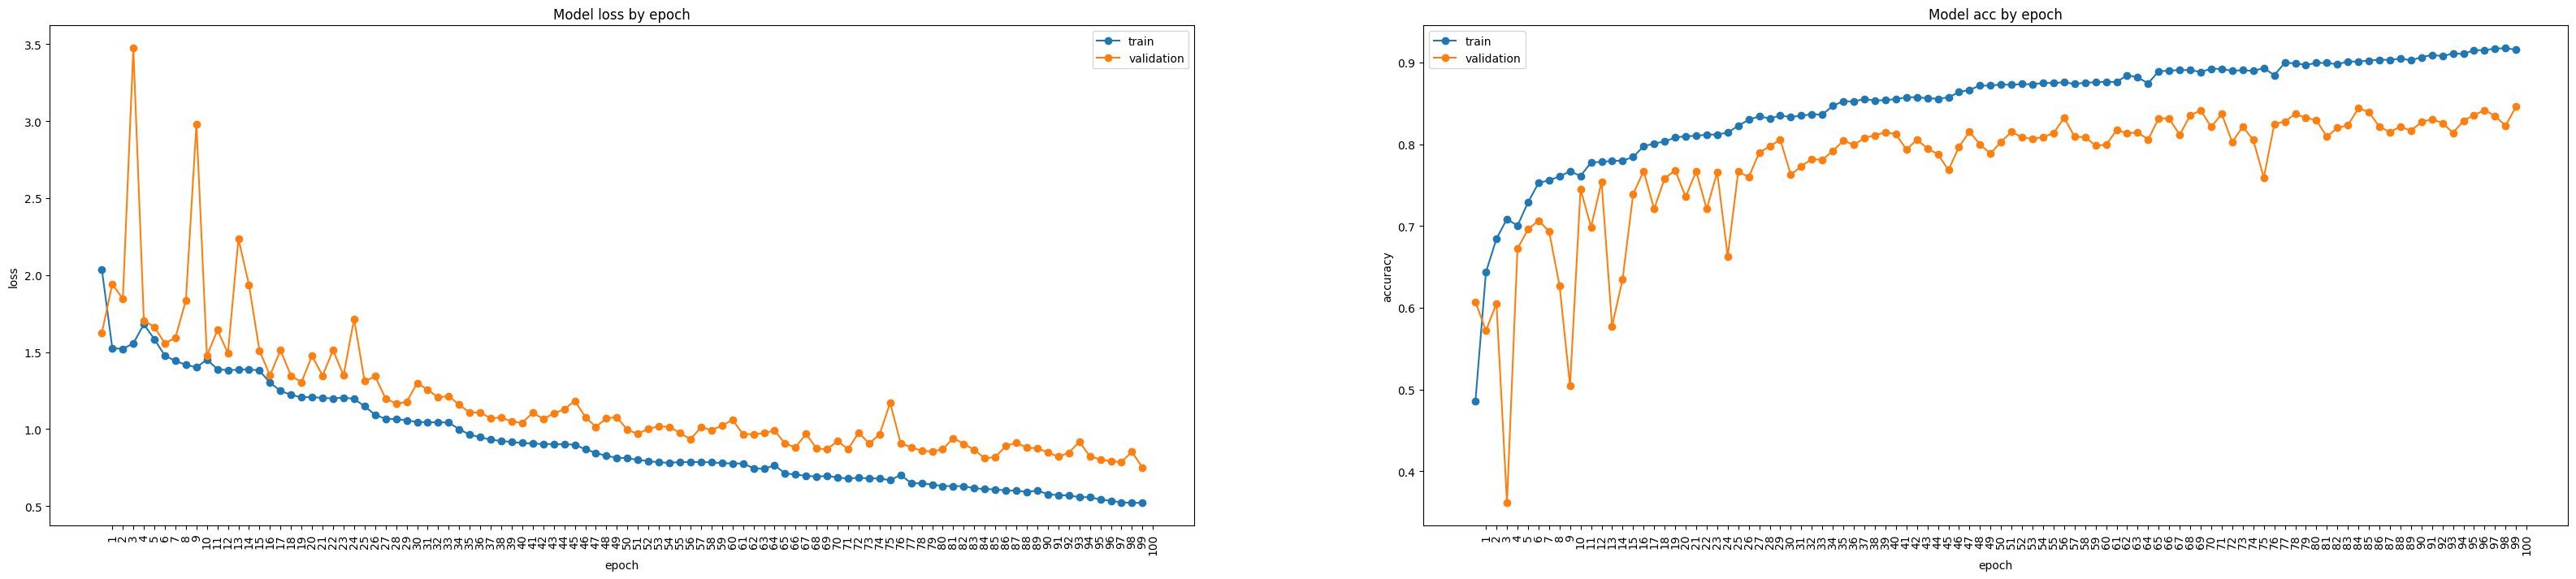

In [20]:
# display the architecture of the model

model.summary()

def dflt(value, default):
    return value if value > 0 else default

xticks = np.arange(start = 1, stop = min(dflt(early_stopping.stopped_epoch, epochs), epochs) + 1)

# evolution plots of accuracies on the training and validation data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,8))

ax1.plot(history.history['loss'],'-o')
ax1.plot(history.history['val_loss'],'-o')
ax1.set_title('Model loss by epoch')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation='vertical')
ax1.legend(['train', 'validation'], loc='best')

ax2.plot(history.history['accuracy'],'-o')
ax2.plot(history.history['val_accuracy'],'-o')
ax2.set_title('Model acc by epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, rotation='vertical')
ax2.legend(['train', 'validation'], loc='best')

plt.show();plt.close();

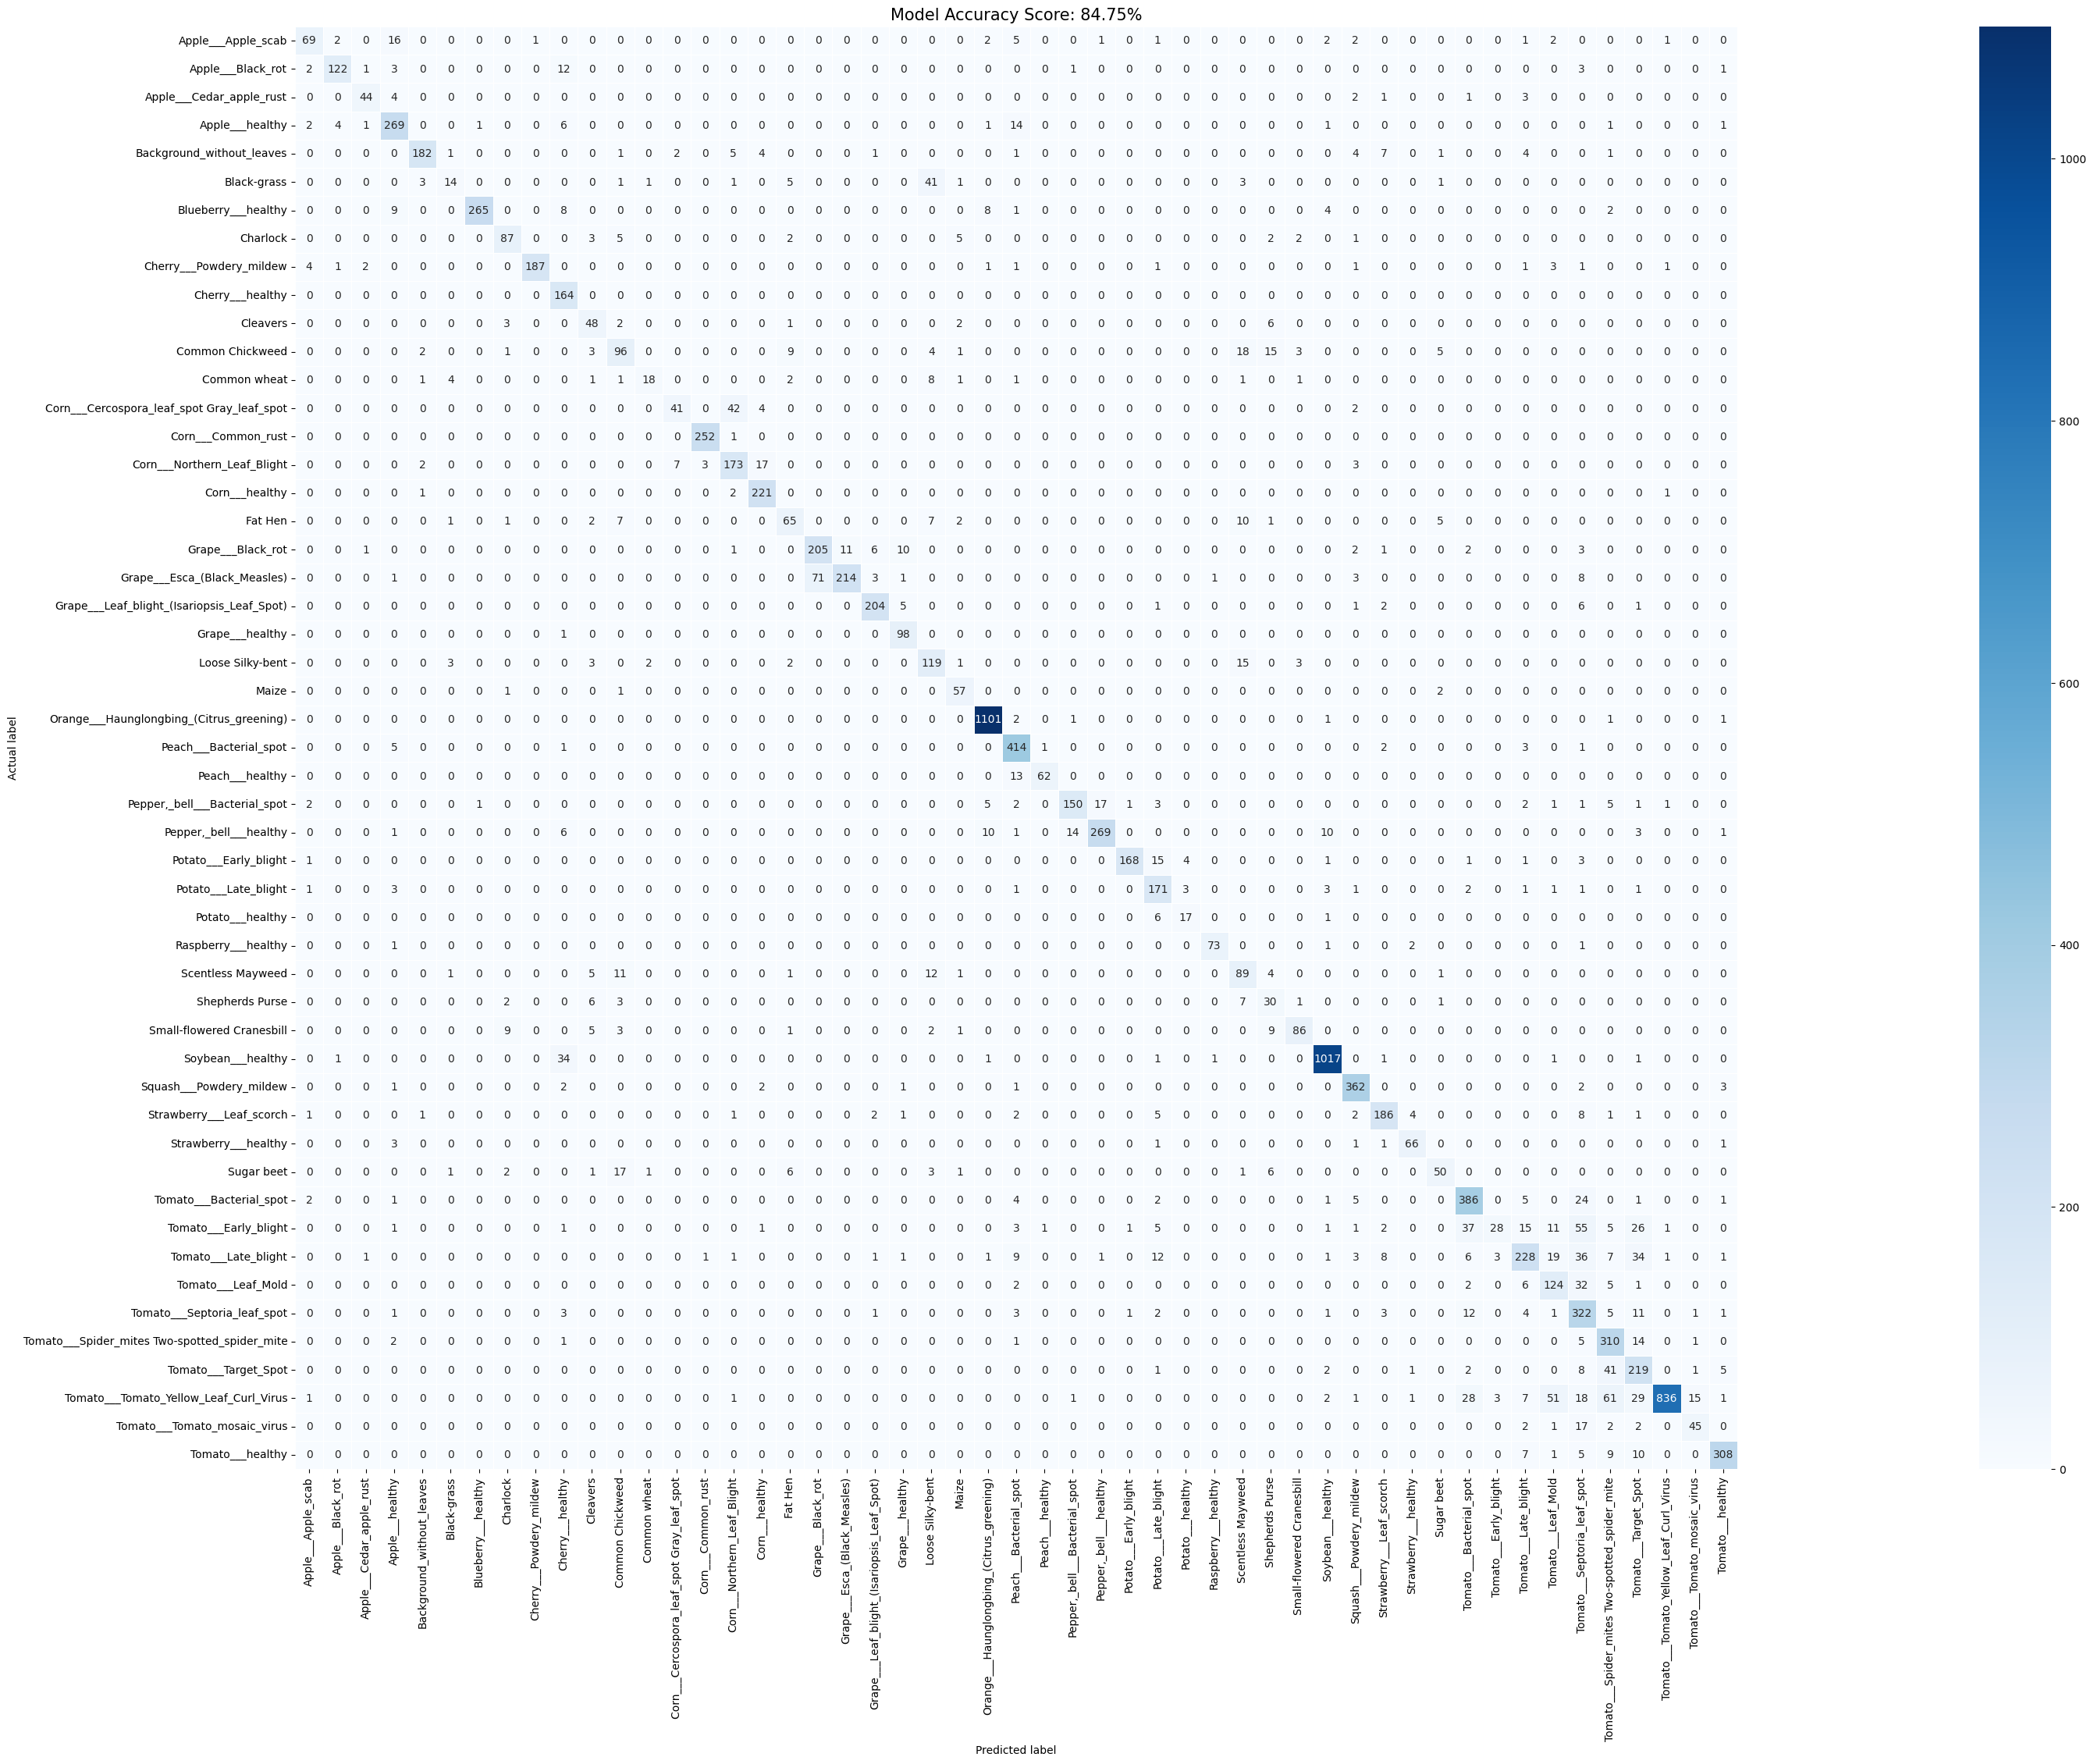

In [37]:
# predict on the test data and generate confusion matrix
test_classes = np.array([])
predicted_classes = np.array([])

for x, y in test_ds:
  predicted_classes = np.concatenate([predicted_classes, np.argmax(model(x, training=False), axis = -1)]).astype(int)
  test_classes = np.concatenate([test_classes, y.numpy()]).astype(int)

loss_acc_tuple = model.evaluate(test_ds, verbose=0)
cm = confusion_matrix(test_classes, predicted_classes)

plt.figure(figsize=(80,24))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

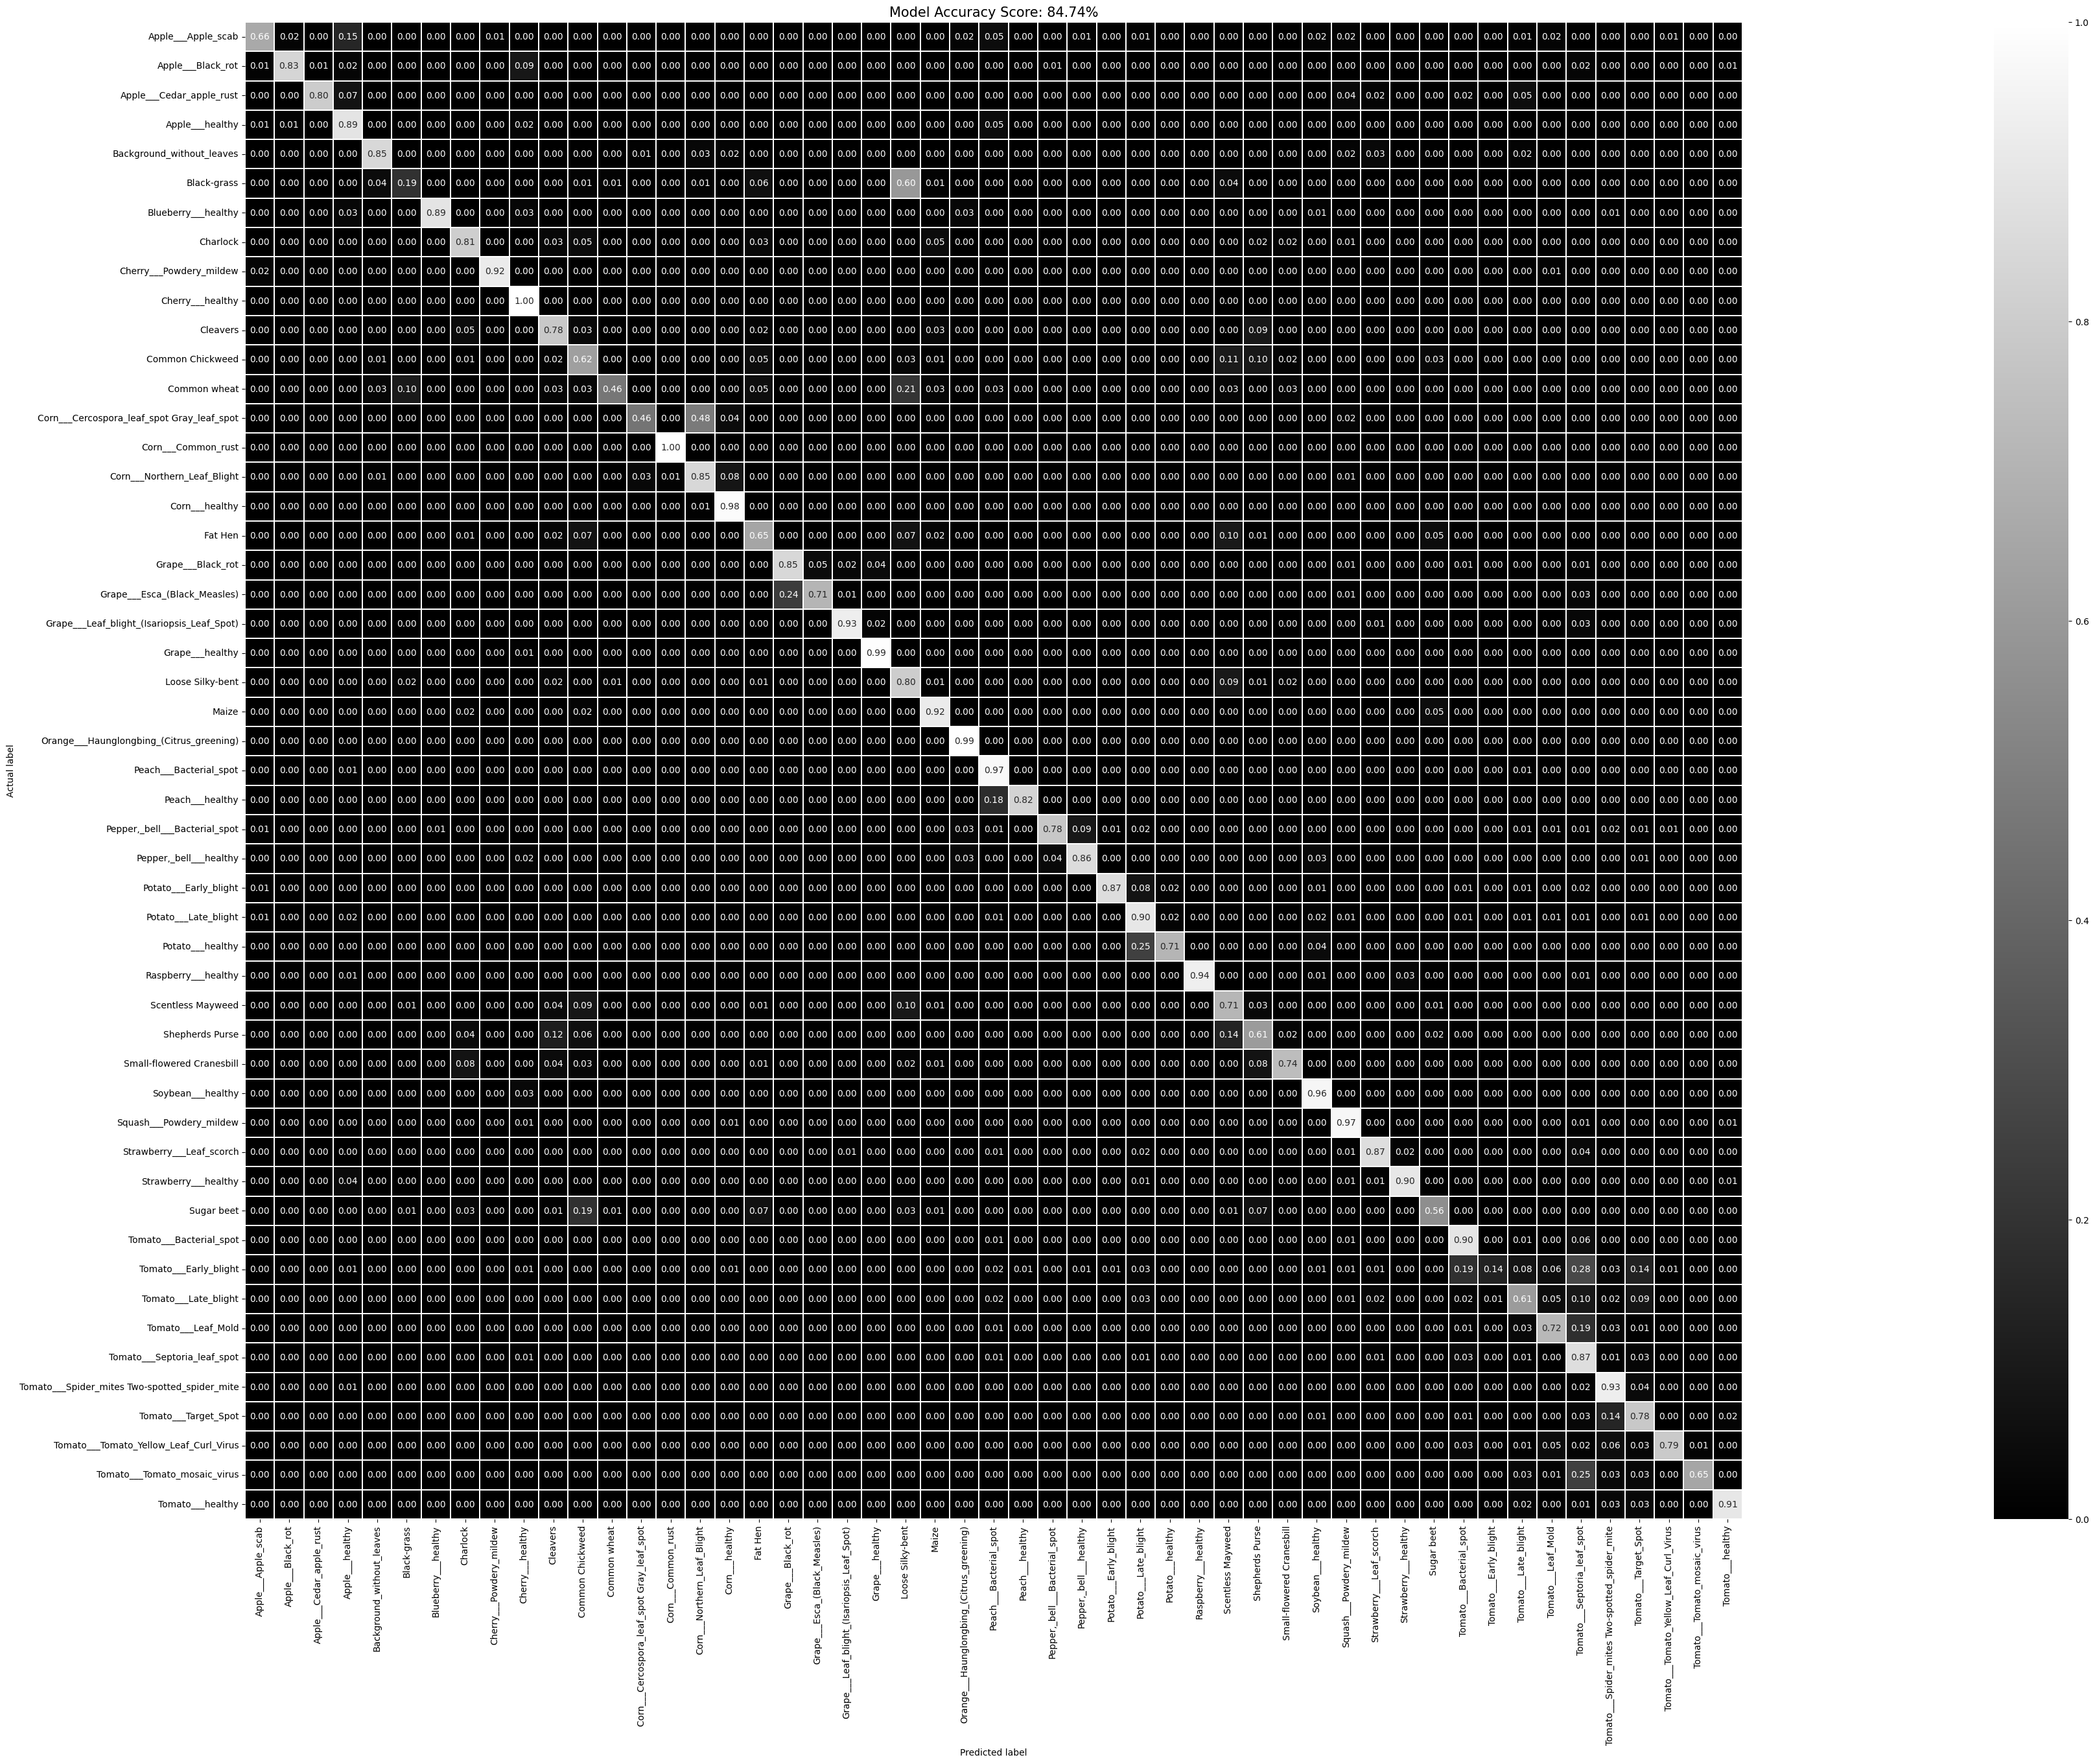

In [34]:
# plot confusion matrix, normalized over actual classes (i.e. rows)
cm_nrm_tr = confusion_matrix(test_classes, predicted_classes, normalize = "true")

plt.figure(figsize=(100,30))
sns.heatmap(cm_nrm_tr, annot=True, fmt=".2f", linewidths=.2, square = True, cmap = 'gray', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

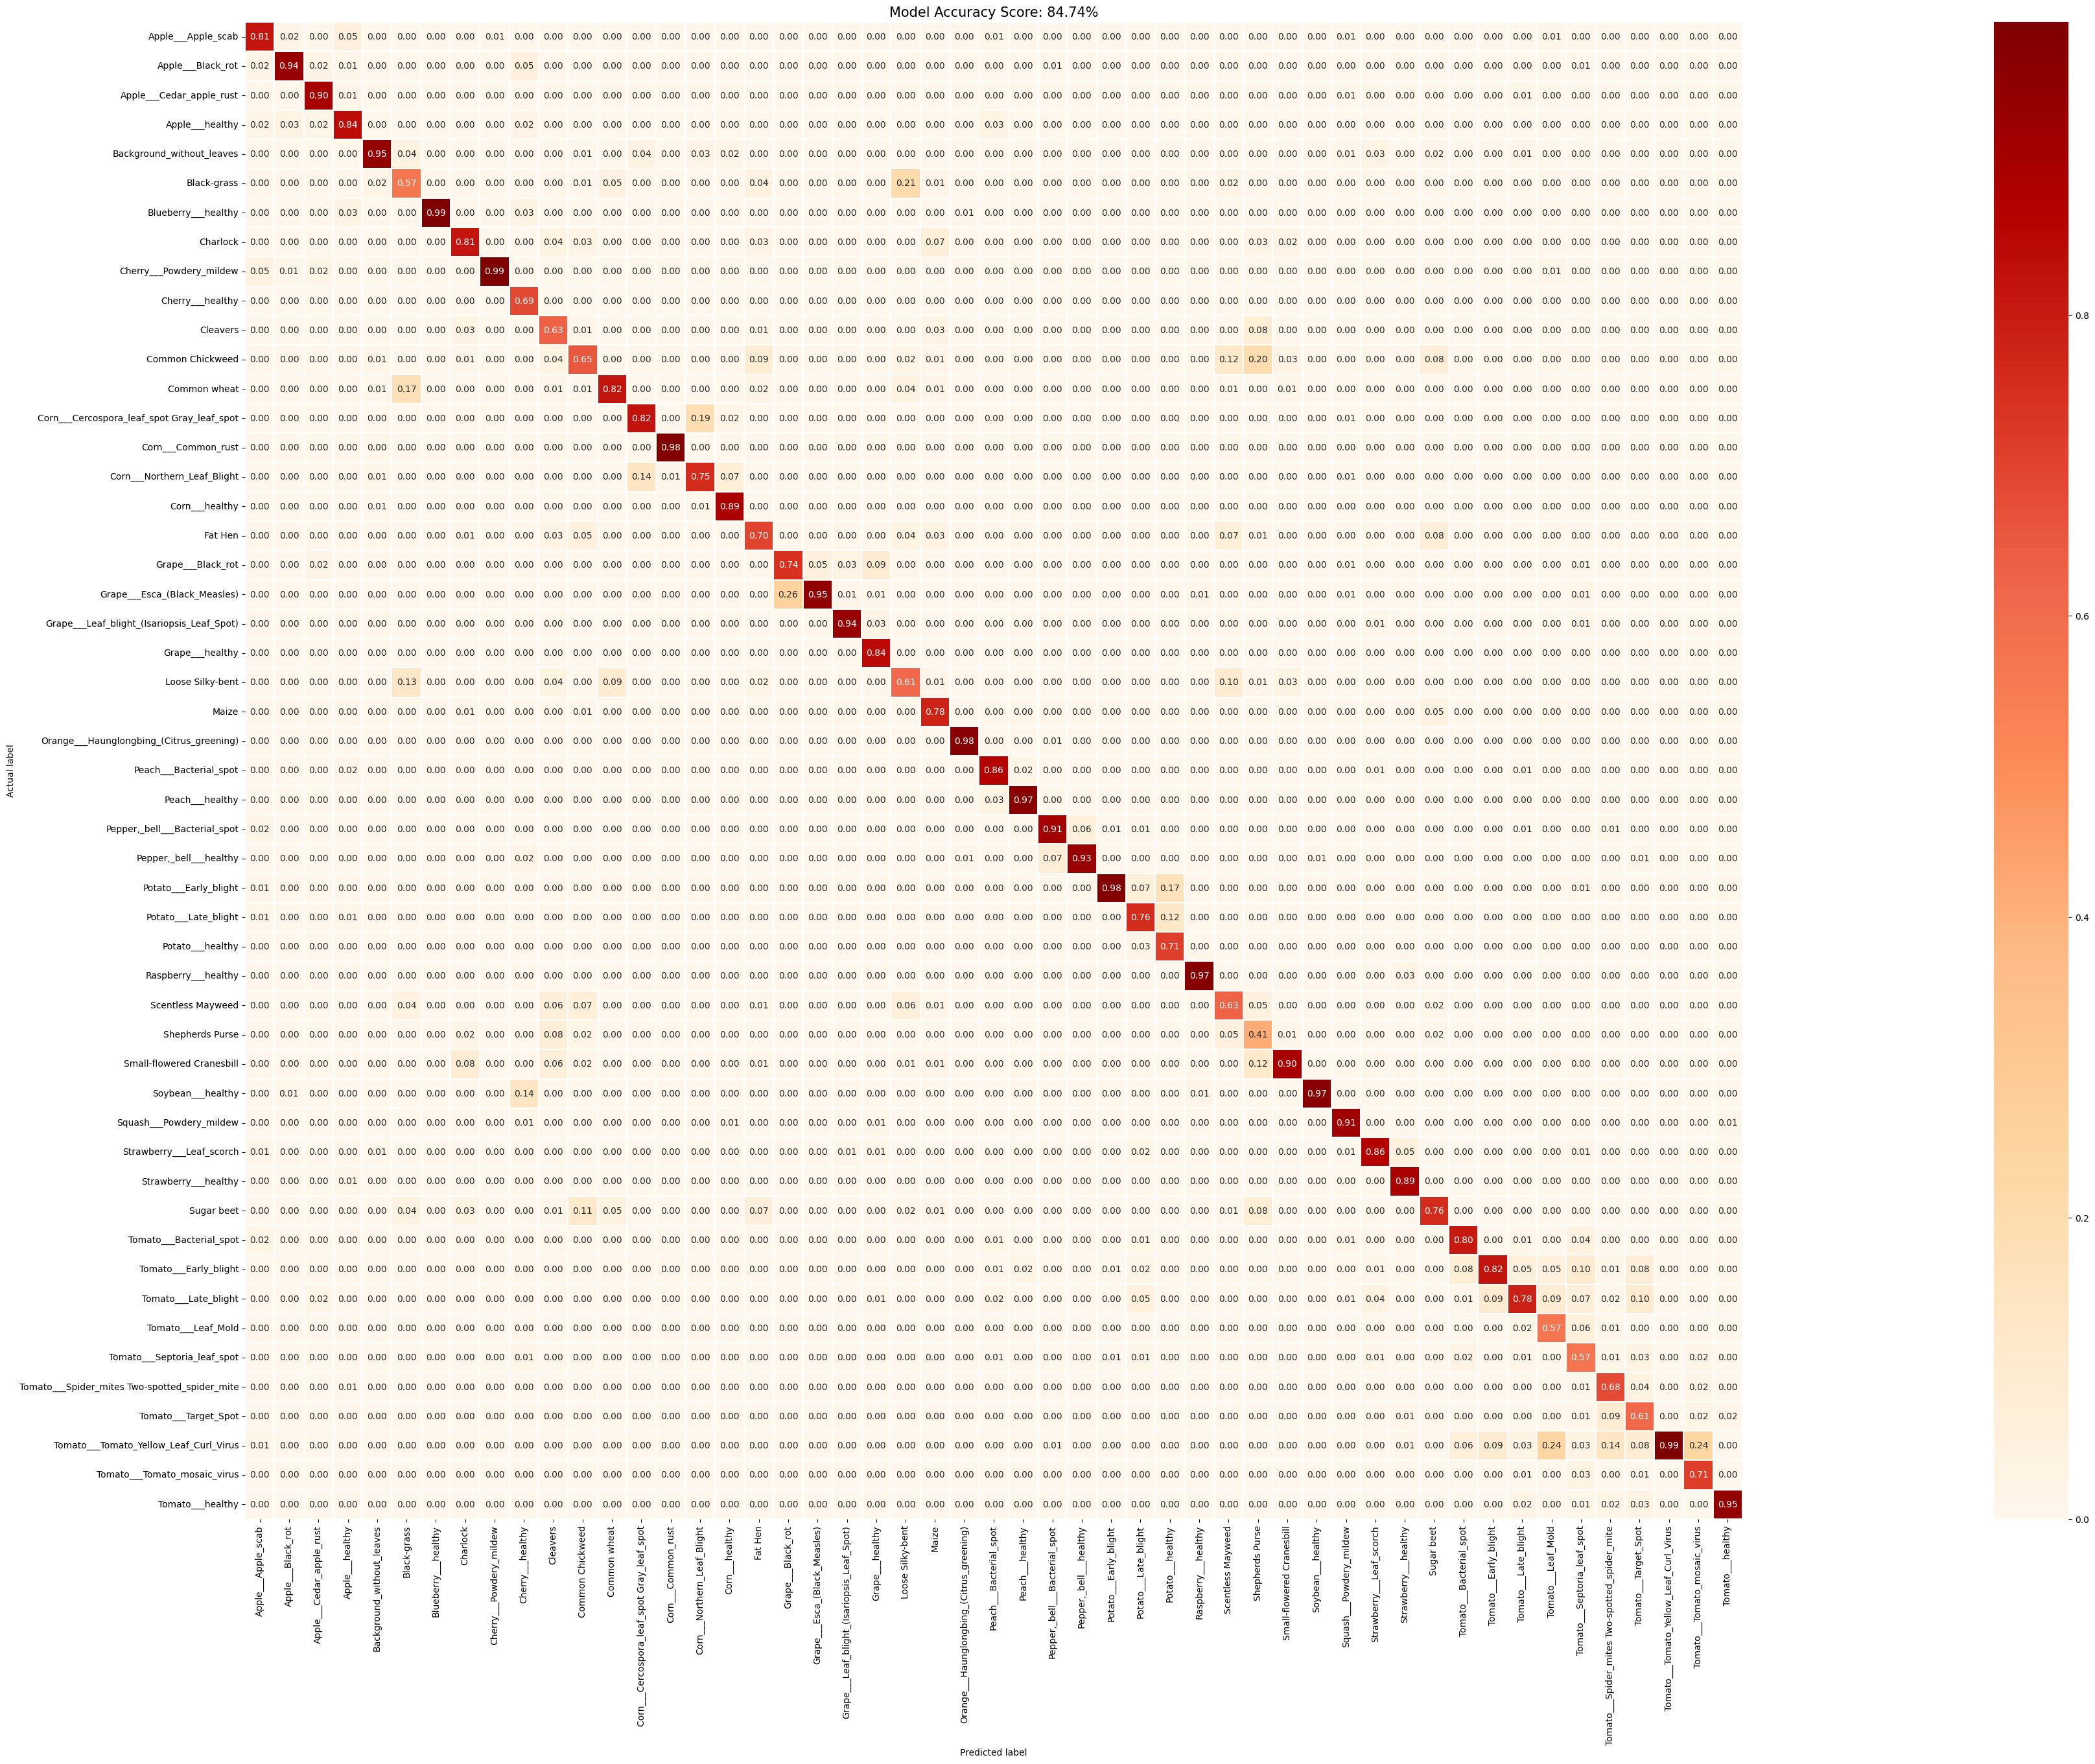

In [36]:
# plot confusion matrix, normalized over predicted classes (i.e. columns)
cm_nrm_pr = confusion_matrix(test_classes, predicted_classes, normalize = "pred")

plt.figure(figsize=(100,30))
sns.heatmap(cm_nrm_pr, annot=True, fmt=".2f", linewidths=.2, square = True, cmap = 'OrRd', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

In [49]:
# predict on the test data and generate confusion matrix & classification report
print(classification_report(test_classes, predicted_classes, target_names=class_names, zero_division= "warn"))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.81      0.66      0.73       105
                            Apple___Black_rot       0.94      0.84      0.89       145
                     Apple___Cedar_apple_rust       0.88      0.80      0.84        55
                              Apple___healthy       0.84      0.89      0.86       301
                    Background_without_leaves       0.95      0.85      0.90       214
                                  Black-grass       0.56      0.20      0.29        71
                          Blueberry___healthy       0.99      0.89      0.94       297
                                     Charlock       0.82      0.81      0.82       107
                      Cherry___Powdery_mildew       0.99      0.92      0.95       204
                             Cherry___healthy       0.69      1.00      0.81       164
                                     Cleav

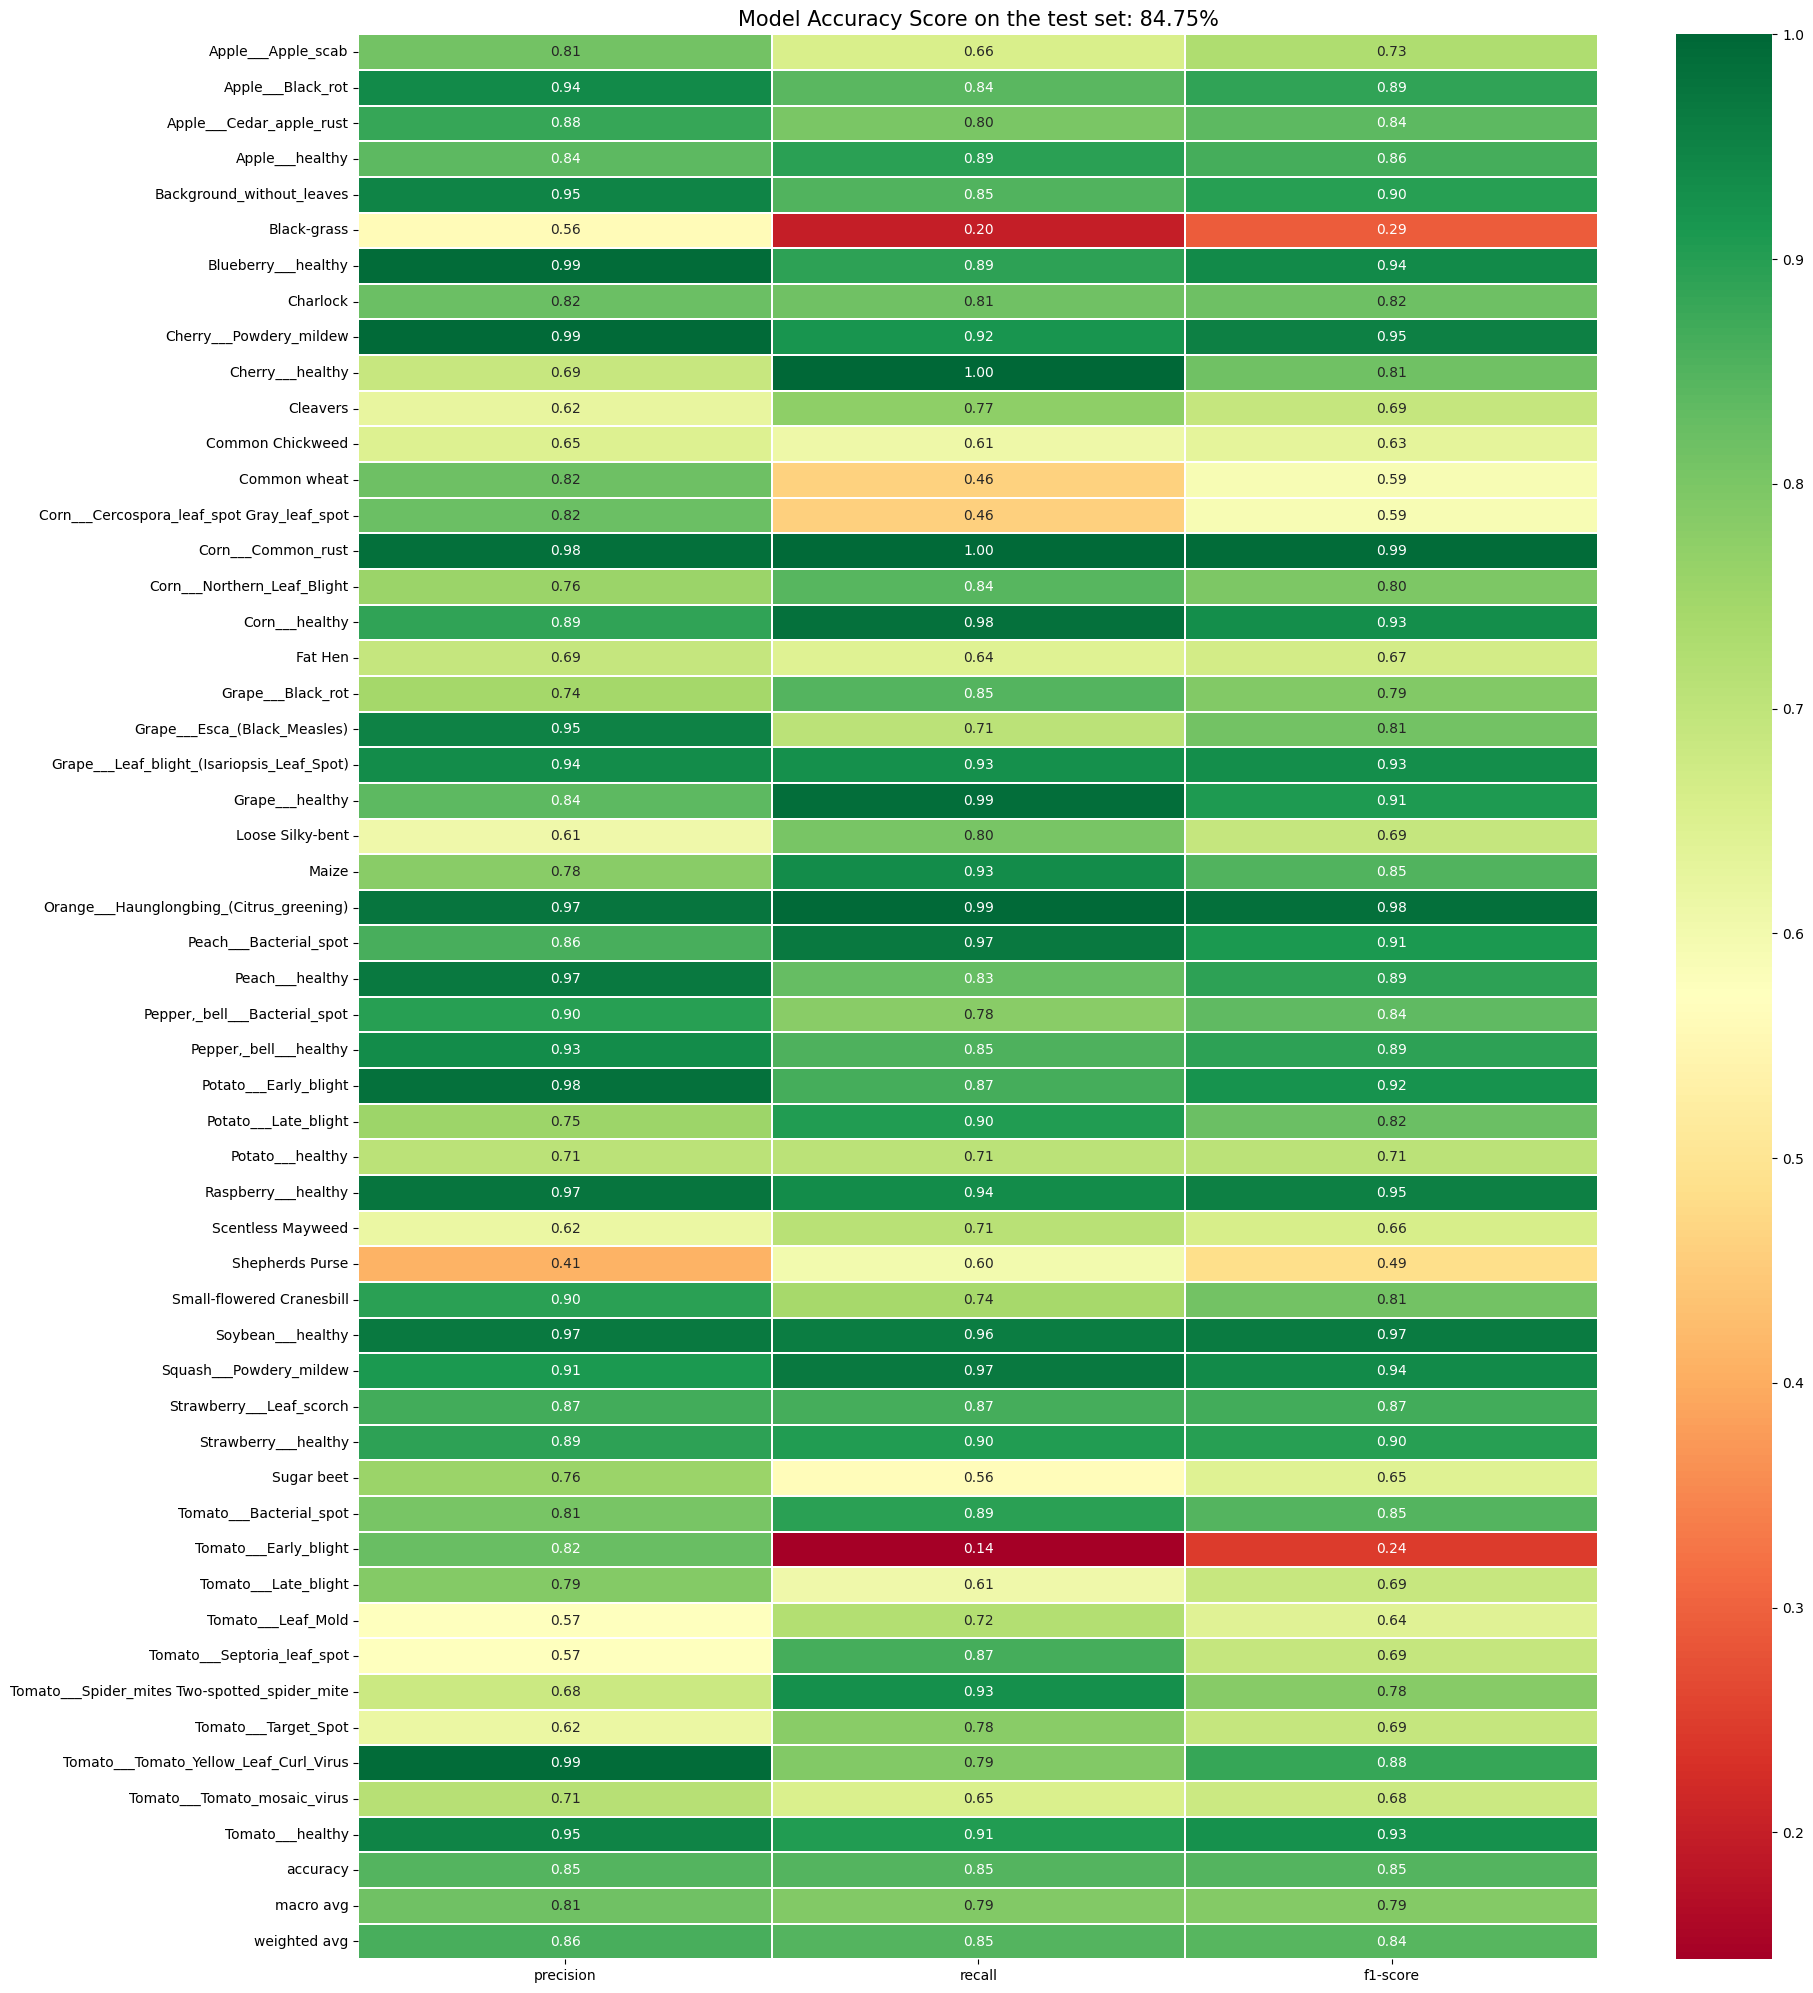

In [113]:
# plot the classification report
clf_report = classification_report(test_classes, predicted_classes, target_names=class_names, zero_division= "warn",output_dict=True)

df = pd.DataFrame(clf_report).iloc[:-1,:].T

plt.figure(figsize=(20,25))
sns.heatmap(df, annot=True, fmt=".2f", linewidths=.2, cmap = 'RdYlGn')
all_sample_title = f'Model Accuracy Score on the test set: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

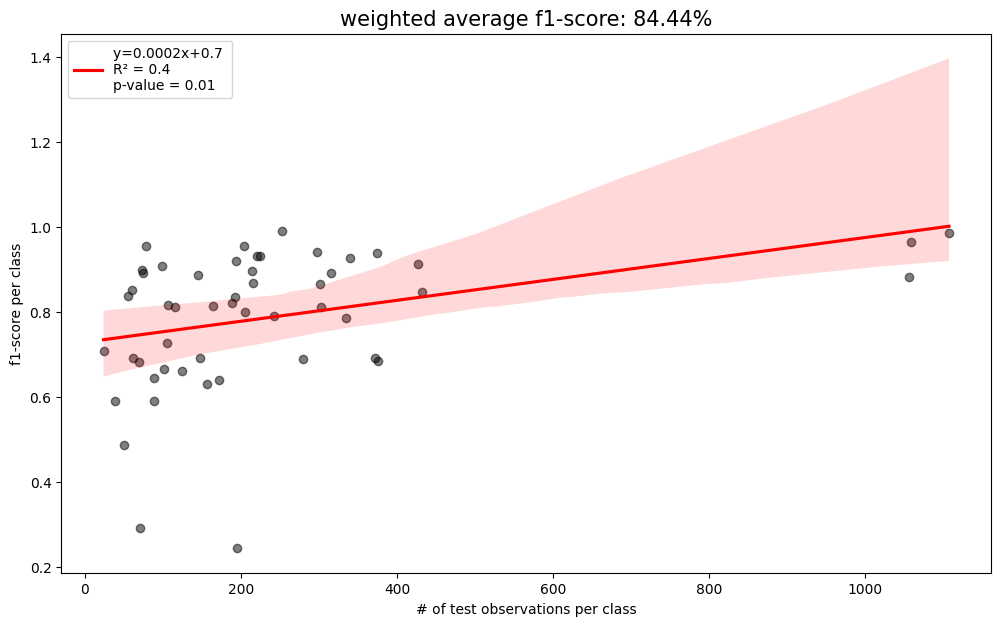

In [81]:
# plot regression model with 99% confidence interval
_,_,fscore,support = score(test_classes,predicted_classes)
_,_,fscore_wavg,_ = score(test_classes,predicted_classes,average='weighted')
slope, intercept, r_value, p_value, _ = linregress(support,fscore)

plt.figure(figsize=(12,7))
ax = sns.regplot(x = support, y = fscore,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red", 'label':"y={0:.4f}x+{1:.1f} \nR² = {2:.1f} \np-value = {3:.2f}".format(slope,intercept,r_value, p_value)},
            ci = 99)
plt.ylabel('f1-score per class')
plt.xlabel('# of test observations per class')
all_sample_title = f'weighted average f1-score: {fscore_wavg:.2%}'
plt.title(all_sample_title, size = 15)
ax.legend()
plt.show();plt.close();

In [23]:
# saving the model on the mounted Google Drive:
model.save(model_save_path_to_file) # creates the 'model.keras' file

***